# Feature selection with kmenas = 2 and threshold fixed on the phase_crswir 

Loading data...


  0%|          | 0/80 [00:00<?, ?it/s]

 70%|███████   | 56/80 [00:15<00:06,  3.89it/s]

Error processing tile_61_20200102_20241230_Préalpes_du_Nord_validation: /Users/arthurcalvi/Data/species/validation/tiles/tile_61_20200102_20241230_Préalpes_du_Nord_validation/features/r_APO.tif: No such file or directory


100%|██████████| 80/80 [00:22<00:00,  3.60it/s]


Running feature subset selection and clustering...


  0%|          | 0/11 [00:00<?, ?it/s]

Writing features for each tile...


  9%|▉         | 1/11 [00:30<05:01, 30.20s/it]

Writing features for each tile...


 18%|█▊        | 2/11 [00:58<04:24, 29.35s/it]

Writing features for each tile...


 27%|██▋       | 3/11 [01:27<03:52, 29.00s/it]

Writing features for each tile...


 36%|███▋      | 4/11 [01:55<03:19, 28.49s/it]

Writing features for each tile...


 45%|████▌     | 5/11 [02:21<02:46, 27.72s/it]

Writing features for each tile...


 55%|█████▍    | 6/11 [02:45<02:11, 26.33s/it]

Writing features for each tile...


 64%|██████▎   | 7/11 [03:06<01:38, 24.60s/it]

Writing features for each tile...


 73%|███████▎  | 8/11 [03:23<01:07, 22.39s/it]

Writing features for each tile...


 82%|████████▏ | 9/11 [03:38<00:39, 19.91s/it]

Writing features for each tile...


 91%|█████████ | 10/11 [03:49<00:17, 17.09s/it]

Writing features for each tile...


100%|██████████| 11/11 [03:56<00:00, 21.46s/it]


Optimal Feature Subset: ['phase_crswir']
Maximum Overall Accuracy: 0.8201303759711975


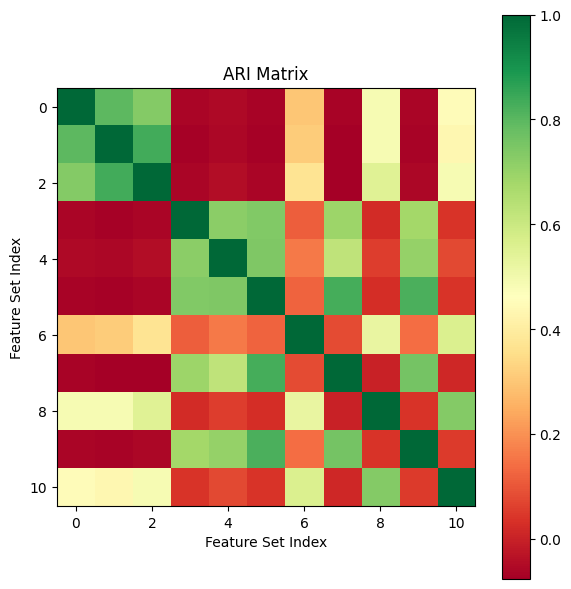

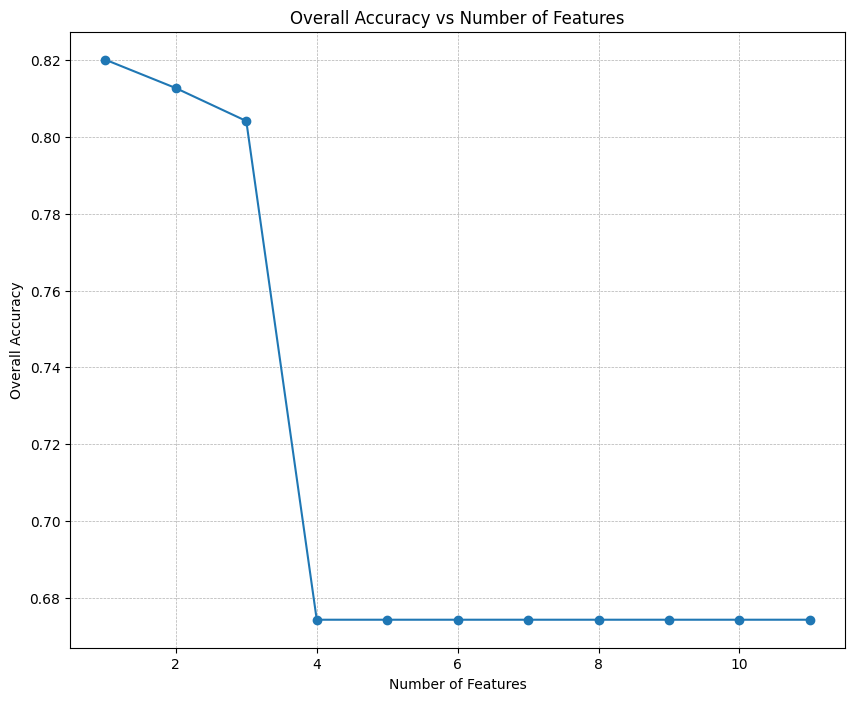

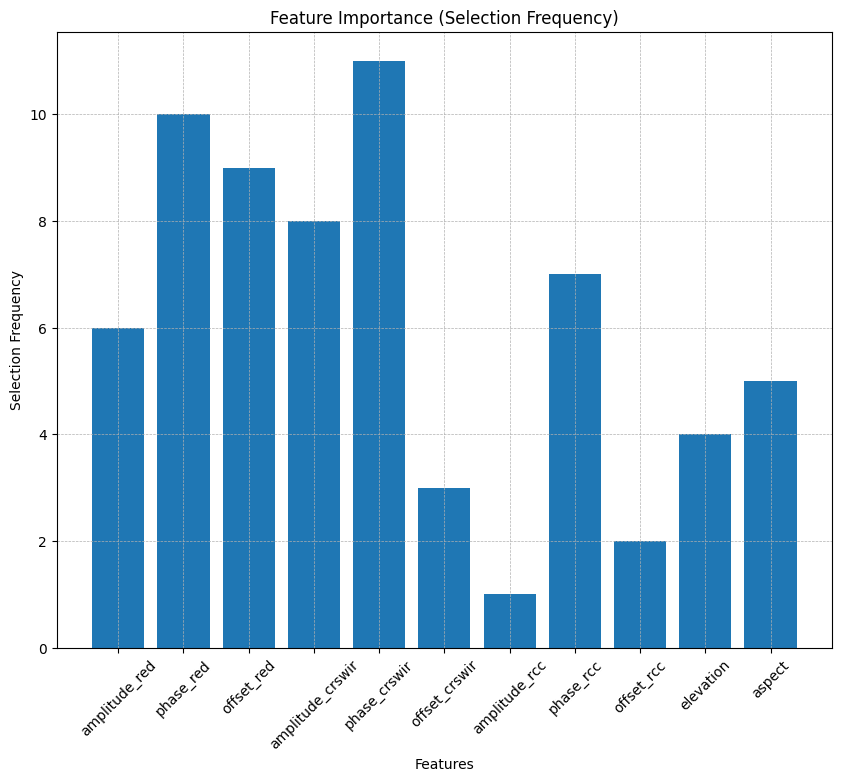

Feature selection completed and optimal feature subset selected.


In [11]:
import os
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import load_folder, calculate_slope_with_dates
from sklearn.impute import SimpleImputer

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Define the genus mapping

phen_mapping = {1: 'deciduous', 2: 'evergreen'}

def save_results_as_tif(output_path: str, data: np.ndarray, reference_path: str):
    """Save clustering results as a .tif file."""
    rgb_path = os.path.join(reference_path, 'rgb')
    rgb_file = [f for f in os.listdir(rgb_path) if f.endswith('.tif')][0]
    rgb_path = os.path.join(rgb_path, rgb_file)
    with rasterio.open(rgb_path) as src:
        meta = src.meta.copy()
        meta.update(dtype=rasterio.uint8, count=1)

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(data.astype(rasterio.uint8), 1)

def load_data_from_tile(path: str) -> tuple:
    """Load and preprocess data from a tile.

    Args:
        path (str): Path to the tile directory.

    Returns:
        tuple: Tuple containing preprocessed features, weights, forest mask, reference path, and tile shape.
    """
    dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
    dates.sort()
    rgb = load_folder(os.path.join(path, 'rgb'))
    chm = rasterio.open(os.path.join(path, 'tree_map', 'CHM2020.tif')).read(1)
    forest_mask = (chm > 250).astype(bool)
    slope_map = calculate_slope_with_dates(rgb[:, 0], dates, len(rgb[:, 0]) / 2, len(rgb[:, 0])) / 100
    weights = (1 - abs(slope_map.ravel())).clip(0, 1)

    path_features = os.path.join(path, 'features')
    r_APO = rasterio.open(os.path.join(path_features, 'r_APO.tif')).read()
    amplitude_map_r, phase_map_r, offset_map_r = r_APO[0], r_APO[1], r_APO[2]
    crswir_APO = rasterio.open(os.path.join(path_features, 'crswir_APO.tif')).read()
    amplitude_map_crswir, phase_map_crswir, offset_map_crswir = crswir_APO[0], crswir_APO[1], crswir_APO[2]
    rcc_APO = rasterio.open(os.path.join(path_features, 'rcc_APO.tif')).read()
    amplitude_map_rcc, phase_map_rcc, offset_map_rcc = rcc_APO[0], rcc_APO[1], rcc_APO[2]
    dem = rasterio.open(os.path.join(path_features, 'elevation_aspect.tif')).read()
    elevation, aspect = dem[0], dem[1]

    features = {
        'amplitude_red': amplitude_map_r.ravel(),
        'phase_red': phase_map_r.ravel(),
        'offset_red': offset_map_r.ravel(),
        'amplitude_crswir': amplitude_map_crswir.ravel(),
        'phase_crswir': phase_map_crswir.ravel(),
        'offset_crswir': offset_map_crswir.ravel(),
        'amplitude_rcc': amplitude_map_rcc.ravel(),
        'phase_rcc': phase_map_rcc.ravel(),
        'offset_rcc': offset_map_rcc.ravel(),
        'elevation': elevation.ravel(),
        'aspect': aspect.ravel()
    }

    filtered_features = {k: v[forest_mask.ravel()] for k, v in features.items()}
    filtered_weights = weights[forest_mask.ravel()]

    # Load reference data
    path_reference = os.path.join(path, 'reference_species')
    tif = [x for x in os.listdir(path_reference) if x.endswith('.tif')]
    reference = rasterio.open(os.path.join(path_reference, tif[0])).read()
    genus = reference[1]
    phen = reference[2]  # Assuming phenology data is stored in the third band
    filtered_genus = genus[forest_mask]
    filtered_phen = phen[forest_mask]

    filtered_features['genus'] = filtered_genus
    filtered_features['phen'] = filtered_phen

    return filtered_features, filtered_weights, forest_mask, chm.shape

def load_data(directory: str) -> tuple:
    """Load and preprocess data from all tiles in the directory.

    Args:
        directory (str): Path to the directory containing tile subdirectories.

    Returns:
        tuple: Tuple containing all features, weights, masks, shapes, and paths for each tile.
    """
    all_features = []
    all_weights = []
    all_ref = []
    tile_shapes = []

    for folder in tqdm(os.listdir(directory)):
        path = os.path.join(directory, folder)
        if folder.endswith('training') or folder.__contains__('.DS_Store') or folder.__contains__('.txt'):
            continue
        try:
            filtered_features, filtered_weights, forest_mask, tile_shape = load_data_from_tile(path)
            all_features.append(pd.DataFrame(filtered_features))
            all_weights.append(filtered_weights)
            all_ref.append(filtered_features['phen'])
            tile_shapes.append((path, forest_mask, tile_shape))
        except Exception as e:
            print(f"Error processing {folder}: {e}")
            continue

    # Stack all features, weights, and references
    all_features_stacked = pd.concat(all_features, ignore_index=True)
    all_weights_stacked = np.concatenate(all_weights)
    all_ref_stacked = np.concatenate(all_ref)

    return all_features_stacked, all_weights_stacked, all_ref_stacked, tile_shapes

# Load data
print("Loading data...")
data_dir = '/Users/arthurcalvi/Data/species/validation/tiles'
all_features_stacked, all_weights_stacked, all_ref_stacked, tile_shapes = load_data(data_dir)

# Preprocess data
features = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']
X = all_features_stacked[features]
y_phen = all_features_stacked['phen']

# Replace infinite values with NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle NaNs by imputing with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Update X with imputed values
X = pd.DataFrame(X_imputed, columns=X.columns)

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define feature subset selection using RFE
def select_features(X, y, num_features):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=num_features)
    fit = rfe.fit(X, y)
    selected_features = [features[i] for i in range(len(features)) if fit.support_[i]]
    return selected_features

# Classify clusters based on the average phase_crswir value
def classify_clusters(X: np.ndarray, clusters: np.ndarray, threshold: float = 0.96) -> np.ndarray:
    cluster_labels = np.zeros(clusters.shape)
    for cluster in np.unique(clusters):
        cluster_mask = clusters == cluster
        mean_phase_crswir = np.mean(X[cluster_mask])
        cluster_labels[cluster_mask] = 2 if mean_phase_crswir > threshold else 1
    return cluster_labels

# Placeholder for optimal feature subset and evaluation metric
optimal_feature_subset = None
max_accuracy = float('-inf')
all_clusters = []

print("Running feature subset selection and clustering...")
# Feature subset selection and clustering
list_accuracy_scores = []
list_subset_features = []
for num_features in tqdm(range(1, len(features) + 1)):
    selected_features = select_features(X_scaled, y_phen, num_features)
    X_subset = X_scaled[:, [features.index(f) for f in selected_features]]

    # Run MiniBatchKMeans clustering
    minibatch_kmeans = MiniBatchKMeans(n_clusters=2, random_state=42)
    clusters = minibatch_kmeans.fit_predict(X_subset, sample_weight=all_weights_stacked)
    all_clusters.append(clusters)

    # Classify clusters using the average phase_crswir value
    phen_predictions = classify_clusters(X_scaled[:, features.index('phase_crswir')], clusters)

    # Evaluate using overall accuracy
    valid_mask = (y_phen != 0)
    accuracy = accuracy_score(y_phen[valid_mask], phen_predictions[valid_mask])
    list_accuracy_scores.append(accuracy)
    list_subset_features.append(selected_features)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        optimal_feature_subset = selected_features

    # Reconstruct cluster maps for each tile
    #writing features 
    print("Writing features for each tile...")
    cluster_maps = []
    index = 0
    for path, forest_mask, tile_shape in tqdm(tile_shapes):
        cluster_map = np.full(tile_shape, 0)
        n_points = forest_mask.ravel().sum()
        cluster_map.ravel()[forest_mask.ravel()] = phen_predictions[index:index + n_points]
        index += n_points
        cluster_maps.append((path, cluster_map))

        # Save results for each tile
        result_dir = os.path.join(path, 'results')
        os.makedirs(result_dir, exist_ok=True)
        output_path = os.path.join(result_dir, f"{'_'.join(selected_features)}_k2.tif")
        save_results_as_tif(output_path, cluster_map, path)

# Compute ARI matrix 
num_feature_sets = len(all_clusters)
ari_matrix = np.zeros((num_feature_sets, num_feature_sets))

for i in range(num_feature_sets):
    for j in range(num_feature_sets):
        ari_matrix[i, j] = adjusted_rand_score(all_clusters[i], all_clusters[j])



print(f"Optimal Feature Subset: {optimal_feature_subset}")
print(f"Maximum Overall Accuracy: {max_accuracy}")

# Visualization of ARI matrix
plt.figure(figsize=(6, 6))
plt.imshow(ari_matrix, cmap='RdYlGn', interpolation='nearest')
plt.title('ARI Matrix')
plt.colorbar()
plt.xlabel('Feature Set Index')
plt.ylabel('Feature Set Index')
plt.tight_layout()
plt.show()

# Visualization of Overall Accuracy vs Number of Features
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(features) + 1), list_accuracy_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Overall Accuracy')
plt.title('Overall Accuracy vs Number of Features')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Visualization of Feature Importance
feature_importance = np.zeros(len(features))
for selected_features in list_subset_features:
    for feature in selected_features:
        feature_importance[features.index(feature)] += 1

plt.figure(figsize=(10, 8))
plt.bar(features, feature_importance)
plt.xlabel('Features')
plt.ylabel('Selection Frequency')
plt.title('Feature Importance (Selection Frequency)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print("Feature selection completed and optimal feature subset selected.")


# Genus-Aspect space

# Phen space`


Loading data...


 70%|███████   | 56/80 [00:16<00:06,  3.82it/s]

Error processing tile_61_20200102_20241230_Préalpes_du_Nord_validation: /Users/arthurcalvi/Data/species/validation/tiles/tile_61_20200102_20241230_Préalpes_du_Nord_validation/features/r_APO.tif: No such file or directory


100%|██████████| 80/80 [00:22<00:00,  3.53it/s]


Running feature subset selection and clustering...


  0%|          | 0/11 [00:00<?, ?it/s]

Optimal number of clusters: 2
Optimal number of features: 1
Optimal features: ['amplitude_rcc']


  9%|▉         | 1/11 [00:02<00:21,  2.16s/it]

Optimal number of clusters: 2
Optimal number of features: 2
Optimal features: ['amplitude_rcc', 'offset_rcc']


 18%|█▊        | 2/11 [00:04<00:19,  2.21s/it]

Optimal number of clusters: 2
Optimal number of features: 3
Optimal features: ['offset_crswir', 'amplitude_rcc', 'offset_rcc']


 27%|██▋       | 3/11 [00:06<00:18,  2.26s/it]

Optimal number of clusters: 2
Optimal number of features: 4
Optimal features: ['offset_crswir', 'amplitude_rcc', 'offset_rcc', 'elevation']


 36%|███▋      | 4/11 [00:09<00:15,  2.27s/it]

Optimal number of clusters: 2
Optimal number of features: 5
Optimal features: ['amplitude_crswir', 'offset_crswir', 'amplitude_rcc', 'offset_rcc', 'elevation']


 45%|████▌     | 5/11 [00:11<00:13,  2.25s/it]

Optimal number of clusters: 2
Optimal number of features: 6
Optimal features: ['phase_red', 'amplitude_crswir', 'offset_crswir', 'amplitude_rcc', 'offset_rcc', 'elevation']


 55%|█████▍    | 6/11 [00:13<00:11,  2.21s/it]

Optimal number of clusters: 2
Optimal number of features: 7
Optimal features: ['amplitude_red', 'phase_red', 'amplitude_crswir', 'offset_crswir', 'amplitude_rcc', 'offset_rcc', 'elevation']


 64%|██████▎   | 7/11 [00:15<00:08,  2.19s/it]

Optimal number of clusters: 2
Optimal number of features: 8
Optimal features: ['amplitude_red', 'phase_red', 'amplitude_crswir', 'offset_crswir', 'amplitude_rcc', 'offset_rcc', 'elevation', 'aspect']


 73%|███████▎  | 8/11 [00:17<00:06,  2.15s/it]

Optimal number of clusters: 2
Optimal number of features: 9
Optimal features: ['amplitude_red', 'phase_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'offset_rcc', 'elevation', 'aspect']


 82%|████████▏ | 9/11 [00:19<00:04,  2.10s/it]

Optimal number of clusters: 2
Optimal number of features: 10
Optimal features: ['amplitude_red', 'phase_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']


 91%|█████████ | 10/11 [00:21<00:02,  2.00s/it]

Optimal number of clusters: 2
Optimal number of features: 11
Optimal features: ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']


100%|██████████| 11/11 [00:22<00:00,  2.09s/it]


Optimal Feature Subset: ['offset_crswir', 'amplitude_rcc', 'offset_rcc']
Minimum Davies-Bouldin Index in Phenology Space: 0.6474884298540335


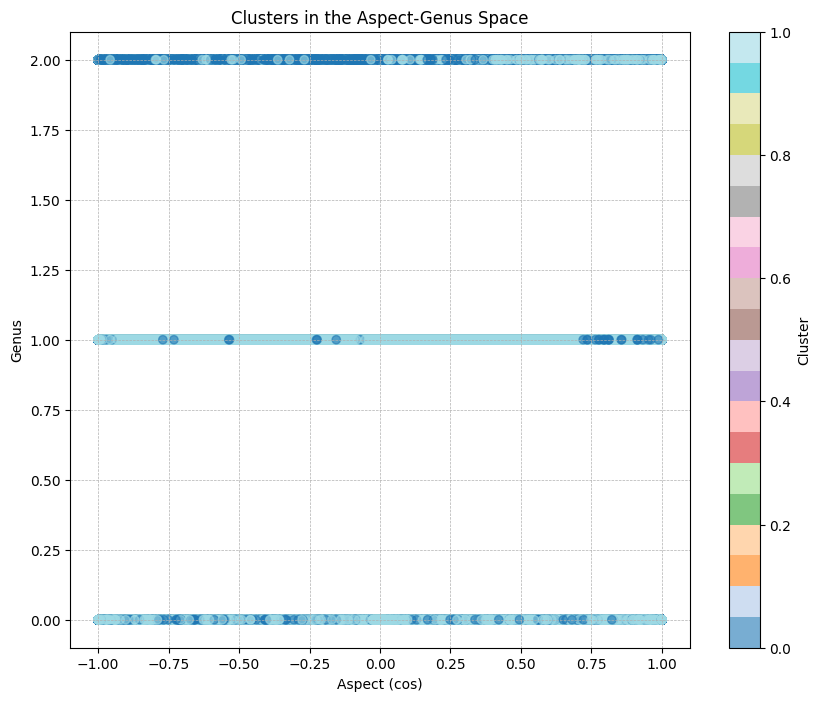

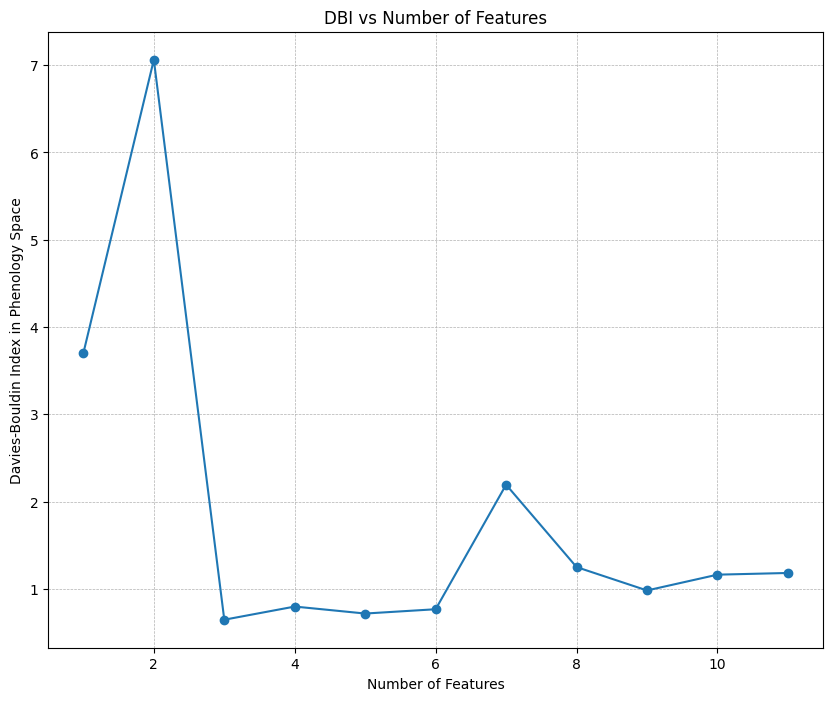

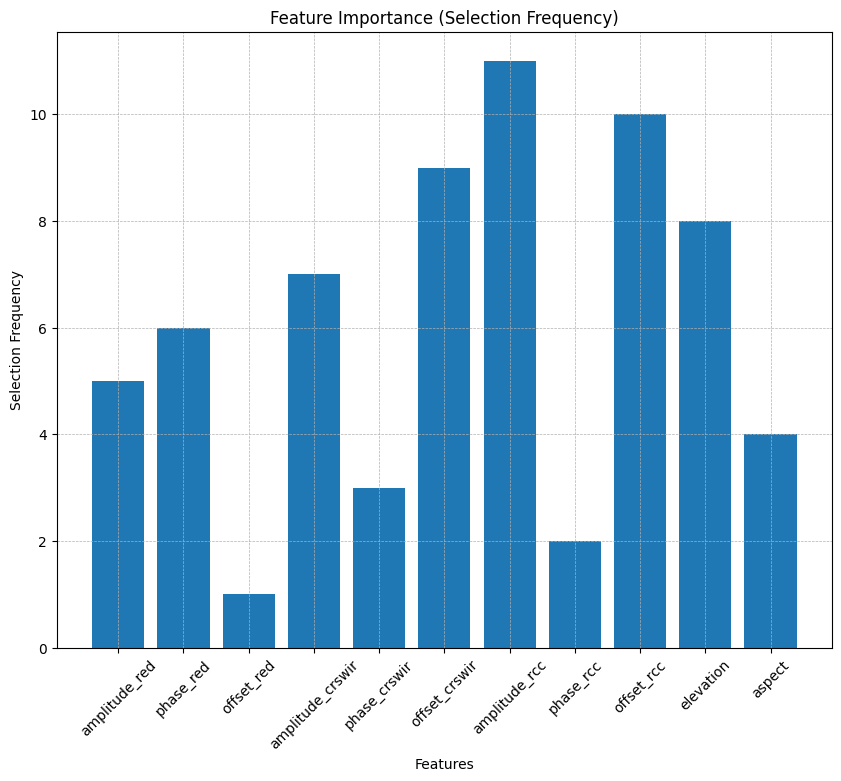

Clustering completed and optimal feature subset selected.


In [16]:
import os
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import load_folder, calculate_slope_with_dates
from sklearn.impute import SimpleImputer

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Define the genus mapping
genus_mapping = {
    1: 'oak', 2: 'fir', 3: 'pine', 4: 'douglas', 5: 'chestnut',
    6: 'spruce', 7: 'larch', 8: 'poplar', 9: 'ash', 10: 'beech',
    11: 'alder', 12: 'birch', 13: 'hornbeam', 14: 'locusts'
}

phen_mapping = {1:'deciduous', 2:'evergreen'} 

def load_data_from_tile(path: str) -> dict:
    """Load and preprocess data from a tile.

    Args:
        path (str): Path to the tile directory.

    Returns:
        dict: Dictionary containing preprocessed features and genus data.
    """
    dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
    dates.sort()
    rgb = load_folder(os.path.join(path, 'rgb'))
    chm = rasterio.open(os.path.join(path, 'tree_map', 'CHM2020.tif')).read(1)
    forest_mask = (chm > 250).astype(bool)
    slope_map = calculate_slope_with_dates(rgb[:, 0], dates, len(rgb[:, 0]) / 2, len(rgb[:, 0])) / 100
    weights = (1 - abs(slope_map.ravel())).clip(0, 1)

    path_features = os.path.join(path, 'features')
    r_APO = rasterio.open(os.path.join(path_features, 'r_APO.tif')).read()
    amplitude_map_r, phase_map_r, offset_map_r = r_APO[0], r_APO[1], r_APO[2]
    crswir_APO = rasterio.open(os.path.join(path_features, 'crswir_APO.tif')).read()
    amplitude_map_crswir, phase_map_crswir, offset_map_crswir = crswir_APO[0], crswir_APO[1], crswir_APO[2]
    rcc_APO = rasterio.open(os.path.join(path_features, 'rcc_APO.tif')).read()
    amplitude_map_rcc, phase_map_rcc, offset_map_rcc = rcc_APO[0], rcc_APO[1], rcc_APO[2]
    dem = rasterio.open(os.path.join(path_features, 'elevation_aspect.tif')).read()
    elevation, aspect = dem[0], dem[1]

    features = {
        'amplitude_red': amplitude_map_r.ravel(),
        'phase_red': phase_map_r.ravel(),
        'offset_red': offset_map_r.ravel(),
        'amplitude_crswir': amplitude_map_crswir.ravel(),
        'phase_crswir': phase_map_crswir.ravel(),
        'offset_crswir': offset_map_crswir.ravel(),
        'amplitude_rcc': amplitude_map_rcc.ravel(),
        'phase_rcc': phase_map_rcc.ravel(),
        'offset_rcc': offset_map_rcc.ravel(),
        'elevation': elevation.ravel(),
        'aspect': aspect.ravel()
    }

    filtered_features = {k: v[forest_mask.ravel()] for k, v in features.items()}
    filtered_weights = weights[forest_mask.ravel()]

    # Load reference data
    path_reference = os.path.join(path, 'reference_species')
    tif = [x for x in os.listdir(path_reference) if x.endswith('.tif')]
    reference = rasterio.open(os.path.join(path_reference, tif[0])).read()
    genus = reference[1]
    phen = reference[2]  # Assuming phenology data is stored in the third band
    filtered_genus = genus[forest_mask]
    filtered_phen = phen[forest_mask]

    filtered_features['genus'] = filtered_genus
    filtered_features['phen'] = filtered_phen

    return filtered_features, filtered_weights

def load_data(directory: str) -> pd.DataFrame:
    """Load and preprocess data from all tiles in the directory.

    Args:
        directory (str): Path to the directory containing tile subdirectories.

    Returns:
        pd.DataFrame: DataFrame containing all features and genus data.
    """
    all_data = []
    all_weights = []

    for folder in tqdm(os.listdir(directory)):
        path = os.path.join(directory, folder)
        if folder.endswith('training') or folder.__contains__('.DS_Store') or folder.__contains__('.txt'):
            continue
        try:
            tile_data, tile_weight = load_data_from_tile(path)
            all_data.append(pd.DataFrame(tile_data))
            all_weights.append(tile_weight)
        except Exception as e:
            print(f"Error processing {folder}: {e}")
            continue

    return pd.concat(all_data, ignore_index=True), np.concatenate(all_weights)

# Example usage
# Set the directory path where your data is stored
print("Loading data...")
data_dir = '/Users/arthurcalvi/Data/species/validation/tiles'
data, all_weights = load_data(data_dir)

# Preprocess data
features = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']
X = data[features]
y_genus = data['genus']
y_phen = data['phen']
aspect = data['aspect']
genus = data['genus']

# Replace infinite values with NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle NaNs by imputing with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Update X with imputed values
X = pd.DataFrame(X_imputed, columns=X.columns)

# Transform aspect
aspect_cos = np.cos(np.radians(aspect))
aspect_sin = np.sin(np.radians(aspect))

# Add transformed aspect to validation space
validation_space = np.stack((y_genus, aspect_cos, aspect_sin), axis=-1)
phen_space = y_phen  # Assuming phen is already a suitable space for DBI calculation

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
validation_space_scaled = scaler.fit_transform(validation_space)
phen_space_scaled = scaler.fit_transform(phen_space.values.reshape(-1, 1))
valid_mask = (y_phen != 0)

# Define feature subset selection using RFE
def select_features(X, y, num_features):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=num_features)
    fit = rfe.fit(X, y)
    selected_features = [features[i] for i in range(len(features)) if fit.support_[i]]
    return selected_features

# Determine the range for the number of clusters
n_genus = len(genus_mapping)
cluster_range = range(2, 2 * 8 + 1)

# Placeholder for optimal feature subset and DBI
optimal_feature_subset = None
min_dbi = float('inf')

print("Running feature subset selection and clustering...")
# Feature subset selection and clustering
list_dbi_validation = []
list_subset_features = []
list_nbr_clusters = []
for num_features in tqdm(range(1, len(features) + 1)):
    selected_features = select_features(X_scaled[valid_mask], y_phen[valid_mask], num_features)
    X_subset = X_scaled[:, [features.index(f) for f in selected_features]]

    best_dbi = float('inf')
    best_k = None

    # Determine optimal number of clusters
    # for k in tqdm(cluster_range):
    #     minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    #     clusters = minibatch_kmeans.fit_predict(X_subset, sample_weight=all_weights)
    #     dbi = davies_bouldin_score(X_subset, clusters)
    #     if dbi < best_dbi:
    #         best_dbi = dbi
    #         best_k = k

    best_k = 2

    # Run MiniBatchKMeans with the optimal number of clusters
    print(f"Optimal number of clusters: {best_k}")
    print(f"Optimal number of features: {num_features}")
    print(f"Optimal features: {selected_features}")
    minibatch_kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42)
    clusters = minibatch_kmeans.fit_predict(X_subset, sample_weight=all_weights)
    list_nbr_clusters.append(best_k)

    # Compute DBI in the phenology space where phen != 0
    dbi_validation = davies_bouldin_score(phen_space_scaled[valid_mask], clusters[valid_mask])
    list_dbi_validation.append(dbi_validation)
    list_subset_features.append(selected_features)
    if dbi_validation < min_dbi:
        min_dbi = dbi_validation
        optimal_feature_subset = selected_features

print(f"Optimal Feature Subset: {optimal_feature_subset}")
print(f"Minimum Davies-Bouldin Index in Phenology Space: {min_dbi}")

# Final MiniBatchKMeans clustering with the optimal feature subset
X_optimal = X_scaled[:, [features.index(f) for f in optimal_feature_subset]]
minibatch_kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42)
clusters = minibatch_kmeans.fit_predict(X_optimal, sample_weight=all_weights)

# Visualization of clusters in the Aspect-Genus space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(aspect_cos, y_phen, c=clusters, cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Aspect (cos)')
plt.ylabel('Genus')
plt.title('Clusters in the Aspect-Genus Space')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Visualization of DBI vs Number of Features
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(features) + 1), list_dbi_validation, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Davies-Bouldin Index in Phenology Space')
plt.title('DBI vs Number of Features')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Visualization of Feature Importance
feature_importance = np.zeros(len(features))
for selected_features in list_subset_features:
    for feature in selected_features:
        feature_importance[features.index(feature)] += 1

plt.figure(figsize=(10, 8))
plt.bar(features, feature_importance)
plt.xlabel('Features')
plt.ylabel('Selection Frequency')
plt.title('Feature Importance (Selection Frequency)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print("Clustering completed and optimal feature subset selected.")
